# Building the final scratch model

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-01-27 12:56:34.763013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading image metadata

In [2]:
def get_image_meta(data_path):
    """Retrieve basic metadata (file_path, category)"""
    
    file_meta = []

    for name in os.listdir(data_path): 
        filepath = os.path.join(data_path, name)

        if '.DS_Store' in filepath:
            continue

        for image_file_name in os.listdir(filepath): 
            image_filepath = os.path.join(filepath, image_file_name)

            attrs = {
                'category': name,
                'file_path': image_filepath,
            }
            file_meta.append(attrs)

    return file_meta 

In [3]:
data_file_path = "../data/clean_fer_2013/"

In [4]:
train_data_folder = data_file_path + "train/"

meta_train = get_image_meta(train_data_folder)

df_meta_train = pd.DataFrame(meta_train)
df_meta_train.head()

,category,file_path
0,happy,../data/clean_fer_2013/train/happy/Training_50...
1,happy,../data/clean_fer_2013/train/happy/Training_70...
2,happy,../data/clean_fer_2013/train/happy/Training_85...
3,happy,../data/clean_fer_2013/train/happy/Training_44...
4,happy,../data/clean_fer_2013/train/happy/Training_63...


In [5]:
val_data_folder = data_file_path + "validation/"

meta_val = get_image_meta(val_data_folder)

df_meta_val = pd.DataFrame(meta_val)
df_meta_val.head()

,category,file_path
0,happy,../data/clean_fer_2013/validation/happy/Public...
1,happy,../data/clean_fer_2013/validation/happy/Public...
2,happy,../data/clean_fer_2013/validation/happy/Public...
3,happy,../data/clean_fer_2013/validation/happy/Public...
4,happy,../data/clean_fer_2013/validation/happy/Public...


## Base Scratch Model Configuration

Here I rebuild the base model I built earlier.

In [6]:
input_shape = (48,48,1)
num_categories = 7 # we have 7 emotions

base_model = tf.keras.Sequential([
    keras.layers.InputLayer(shape=input_shape),

    # First Convolutional Layer (32 filters)
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Layer (64 filters)
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Layer (128 filters)
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),

    # Final output layer
    keras.layers.Dense(num_categories, activation='softmax') 
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)

loss = keras.losses.CategoricalCrossentropy(from_logits=False)

base_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 691,335 (2.64 MB)

 Trainable params: 691,335 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

## Preparing the datasets for training

I need a `label_encoder` to one-hot-encode the categories (which are currently in string format).

I have also added a `preprocess_input` function. At the moment this normalizes the image (converting all pixels into a [0,1] range) but it can be expanded in the future to perform additional steps e.g. to resize images and convert images to grayscale.

I shuffle the dataset to prevent any kind of order bias.

I use `prefetch` to improve performance: it will start preparing the next batch of data while the model is training the current batch.

We start with a batch_size of 32 to balance memory consumption (not too much data is loaded into memory) and speed (might take longer than a larger batch size but hopefully not too bad).

In [37]:
# Augmentation Layers
rotation_layer = tf.keras.layers.RandomRotation(0.05)  # Rotate by up to 5% of 360 degrees i.e. 18 degrees
zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.05, width_factor=0.05)  # Zoom by 5%
shift_layer = tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05)  # Shift by 5%
flip_layer = tf.keras.layers.RandomFlip("horizontal")

def augment_image(image):
    """Augment the image with a random rotation, zoom, translation and flip"""
    image = rotation_layer(image) 
    image = zoom_layer(image) 
    image = shift_layer(image)  
    image = flip_layer(image)
    
    return image



def preprocess_input(image_path, should_augment_image=False):
    """Preprocess Input"""
    try:
        image_file = tf.io.read_file(image_path)
    except:
        print(f"Issue loading {image_file}")
        return None

    image = tf.image.decode_jpeg(image_file, channels=1)
    image = tf.image.resize(image, (48, 48))

    if should_augment_image:
        image = augment_image(image)
        
    image = image / 255.0 
    return image

def create_label_encoder(categories, output_mode='one_hot'):
    """Create a mapping from category names to integer indices and perform one hot encoding by default"""
    return tf.keras.layers.StringLookup(vocabulary=categories, 
                                                output_mode=output_mode, 
                                                num_oov_indices=0)

def create_dataset(image_paths, labels, label_encoder, should_augment_image=False, batch_size=32):
    """Load the dataset from file paths, apply preprocessing and group into batches"""
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_input(x,should_augment_image=should_augment_image), tf.squeeze(label_encoder(y))))
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(buffer_size=1000)  # Shuffle the dataset
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)  # Prefetch for better performance
    return dataset

In [38]:
train_labels = df_meta_train["category"].values
train_image_paths = df_meta_train["file_path"].values

val_labels = df_meta_val["category"].values
val_image_paths = df_meta_val["file_path"].values

categories = list(df_meta_train["category"].unique())
label_encoder = create_label_encoder(categories, output_mode='one_hot')
label_encoder_for_weights = create_label_encoder(categories, output_mode='int')

train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=False, batch_size=32)
val_dataset = create_dataset(val_image_paths, val_labels, label_encoder, should_augment_image=False, batch_size=32)

In [9]:
expected_num_iterations_per_epoch = len(train_dataset)
length_training_data = len(train_dataset) * 32
length_validation_data = len(val_dataset) * 32

expected_num_iterations_per_epoch, length_training_data, length_validation_data

(837, 26784, 3488)

## Training the base model

I train the initial base model across 30 epochs to get a sense of its general performance. The default learning rate seems quite low so I wanted to train for more than the standard 10 epochs.

In [10]:
base_history = base_model.fit(
    train_dataset,          
    epochs=30,           
    validation_data=val_dataset  
)

Epoch 1/30


2025-01-25 10:58:46.596878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:3: Filling up shuffle buffer (this may take a while): 453 of 1000
2025-01-25 10:58:54.942556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1737802734.943253     396 service.cc:148] XLA service 0x7f8c24059f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737802734.943277     396 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-01-25 10:58:54.979333: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737802735.169847     396 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-25 10:58:55.419919: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[3

 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2065 - loss: 1.9406

I0000 00:00:1737802736.823548     396 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


765/837 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2367 - loss: 1.8713

2025-01-25 10:58:59.690788: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,32,48,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,1,48,48]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-25 10:58:59.700287: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[15,64,24,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,32,24,24]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

834/837 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2380 - loss: 1.8685

2025-01-25 10:59:03.839390: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,48,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,48,48]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-01-25 10:59:03.849643: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,64,24,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,24,24]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationF

837/837 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.2381 - loss: 1.8684 - val_accuracy: 0.2516 - val_loss: 1.8183
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2545 - loss: 1.8293 - val_accuracy: 0.2516 - val_loss: 1.8114
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2804 - loss: 1.7944 - val_accuracy: 0.2516 - val_loss: 1.8161
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2448 - loss: 1.8371 - val_accuracy: 0.2516 - val_loss: 1.8095
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2506 - loss: 1.8270 - val_accuracy: 0.2490 - val_loss: 1.8070
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2530 - loss: 1.7854 - val_accuracy: 0.2895 - val_loss: 1.7169
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2849 - loss: 1.7276 - val_accuracy: 0.3097 - val_loss: 1.6487
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3050 - loss: 1.6784 - val_accuracy: 0.4063 - va

**Evaluation**

Looking at these first results, you can see that the accuracy on the validation set doesn't get much better than 50%. 

You can also see that the validation loss starts to increase after around 18 epochs, which can be an indication of overfitting.

50% is not a great accuracy score and training for longer with the current model doesn't seem to help. Before we start tweaking our current model, it would be interesting to see if a pretrained model will give us better performance. 

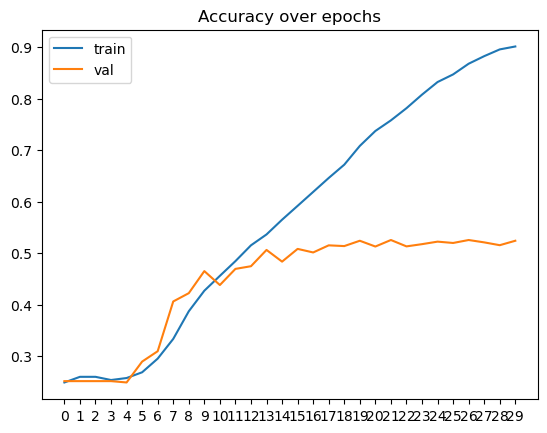

In [11]:
plt.plot(base_history.history["accuracy"], label="train")
plt.plot(base_history.history["val_accuracy"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

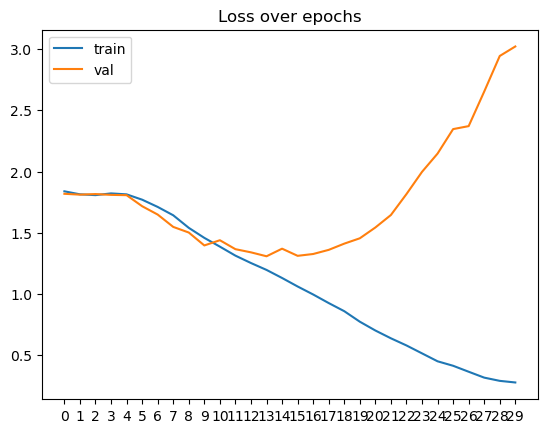

In [12]:
plt.plot(base_history.history["loss"], label="train")
plt.plot(base_history.history["val_loss"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Improving the model

In [13]:
def build_model(learning_rate=0.001, dense_layer_units=[128,64], drop_rate=0):
    input_shape = (48,48,1)
    num_categories = 7 

    base_model = tf.keras.Sequential([
        keras.layers.InputLayer(shape=input_shape),
    
        # First Convolutional Layer (32 filters)
        keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
        # Second Convolutional Layer (64 filters)
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
        # Third Convolutional Layer (128 filters)
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Flatten()
    ])

    # Add additional dense layers
    for unit in dense_layer_units:
        base_model.add(keras.layers.Dense(unit, activation='relu'))
        # Add dropout
        if drop_rate > 0:
            base_model.add(keras.layers.Dropout(drop_rate))
            
    
    # Final output layer
    base_model.add(keras.layers.Dense(num_categories, activation='softmax')) 

    optimizer = keras.optimizers.Adam(learning_rate)
    
    loss = keras.losses.CategoricalCrossentropy(from_logits=False)
    
    base_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return base_model
    

### 1. Class Imbalance: adjust the loss function

We know we have an imbalanced dataset and we explored methods of rectifying this in the EDA. I will go with the simplest approach for just now: adjusting the loss function so that under-represented classes have larger weight when the loss function is calculated. I can achieve this by passing in a class_weight dictionary. 

In [39]:
def calculate_class_weights(df_meta, label_encoder_for_weights):
    # Sort categories alphabetically and get counts
    category_counts = (
        df_meta["category"]
        .value_counts()
        .reset_index()
        .sort_values(by="category")
        .reset_index(drop=True)
    )
    # Get the index for each category from the label encoder
    category_counts["encoded_index"] = category_counts["category"].apply(
        lambda x: label_encoder_for_weights(x).numpy()
    )

    # Calculate the weights
    category_counts["weights"] = np.sum(category_counts["count"]) / category_counts["count"]
    
    # Normalize the weights
    category_counts["normalized_weights"] = category_counts["weights"] / np.sum(category_counts["weights"])
    
    # Map the encoded index to the weight
    class_weight_dict = dict(zip(category_counts["encoded_index"], category_counts["normalized_weights"]))
    
    return class_weight_dict

In [40]:
calculate_class_weights(df_meta_train, label_encoder_for_weights)

{5: 0.06450800153432945,
 6: 0.6436927464930938,
 2: 0.06318039622570737,
 0: 0.03440921133717932,
 4: 0.05061376066274168,
 1: 0.052271054725044945,
 3: 0.09132482902190346}

In [16]:
# We use the same model configuration as before
class_weight_model = build_model()

class_weight_history = class_weight_model.fit(
    train_dataset,          
    epochs=30,           
    validation_data=val_dataset,
    class_weight=class_weight_dict # Add Class Weights
)

Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1722 - loss: 0.2301 - val_accuracy: 0.1694 - val_loss: 2.6304
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1927 - loss: 0.1959 - val_accuracy: 0.1694 - val_loss: 2.4287
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1583 - loss: 0.1950 - val_accuracy: 0.1694 - val_loss: 2.4796
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1769 - loss: 0.1928 - val_accuracy: 0.1694 - val_loss: 2.6009
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2192 - loss: 0.1852 - val_accuracy: 0.1817 - val_loss: 2.2764
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1924 - loss: 0.1823 - val_accuracy: 0.2257 - val_loss: 2.1432
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2510 - loss: 0.1735 - val_accuracy: 0.2602 - val_loss: 1.8694
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2799 - loss: 0.1655 - val_accuracy: 0

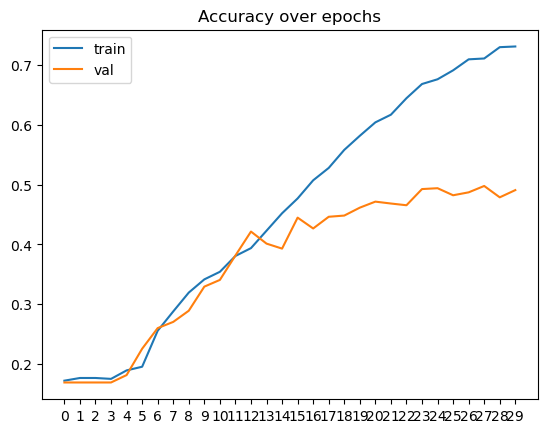

In [17]:
plt.plot(class_weight_history.history["accuracy"], label="train")
plt.plot(class_weight_history.history["val_accuracy"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

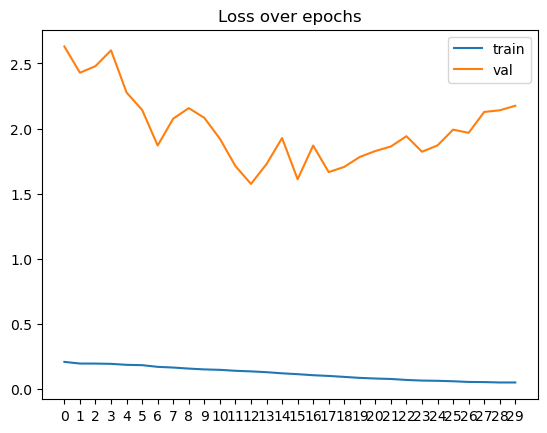

In [18]:
plt.plot(class_weight_history.history["loss"], label="train")
plt.plot(class_weight_history.history["val_loss"], label="val")
plt.xticks(np.arange(30))
plt.legend()
plt.title("Loss over epochs")
plt.show()

**Evaluation**

Although the accuracy on our validation setting isn't much better from catering for class imbalance, the results seem improved and perhaps importantly accuracy and loss are arguably still improving after 30 epochs. We don't see the same overfitting issue we had initially. And although the loss function starts to climb a bit for the validation set, it is lower than its starting value.

This suggests that the addition was positive and that perhaps if we trained the model for more epochs we would get a better result.

### 2. Data Augmentation

I have added an additional function to our dataset creator that will augment images. I have chosen the same settings used in the EDA.

I apply transformations to the training dataset but NOT the validation dataset. When we use this in the training dataset, changes are applied randomly but we do not want randomness in our validation dataset: we want the same dataset to be evaluated against each model so we do not change this.

**Next steps: Additional Epochs**

Given the previous results, I will increase the number of epochs of training from 30 to 50 to see if the accuracy improves with more time.

In [19]:
# We use the same model configuration as before
data_aug_model = build_model()

# We now add augmentation to our training set
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=True, batch_size=32)

expected_num_iterations_per_epoch = len(train_dataset)
length_training_data = len(train_dataset) * 32
length_validation_data = len(val_dataset) * 32

# Augmentation ddoes not change the number of images just 
expected_num_iterations_per_epoch, length_training_data, length_validation_data

(837, 26784, 3488)

In [21]:
data_aug_history = data_aug_model.fit(
    train_dataset,          
    epochs=50,           
    validation_data=val_dataset,
    class_weight=class_weight_dict 
)

Epoch 1/50


2025-01-25 11:17:44.489679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 407 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2418 - loss: 0.2007

2025-01-25 11:17:54.901808: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.1848 - loss: 0.1905 - val_accuracy: 0.1694 - val_loss: 2.2745
Epoch 2/50


2025-01-25 11:18:08.357045: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 412 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1285 - loss: 0.1791

2025-01-25 11:18:18.645877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.1635 - loss: 0.1882 - val_accuracy: 0.1694 - val_loss: 2.1353
Epoch 3/50


2025-01-25 11:18:32.124236: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 415 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3235 - loss: 0.2100

2025-01-25 11:18:42.182768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.1790 - loss: 0.1887 - val_accuracy: 0.1694 - val_loss: 2.7609
Epoch 4/50


2025-01-25 11:18:55.647707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 412 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1153 - loss: 0.1852

2025-01-25 11:19:05.979441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.1523 - loss: 0.1830 - val_accuracy: 0.1694 - val_loss: 2.0858
Epoch 5/50


2025-01-25 11:19:19.441438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 410 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1176 - loss: 0.1700

2025-01-25 11:19:29.797624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.1732 - loss: 0.1819 - val_accuracy: 0.1694 - val_loss: 2.1360
Epoch 6/50


2025-01-25 11:19:43.270517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 404 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2747 - loss: 0.1995

2025-01-25 11:19:53.894383: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.1784 - loss: 0.1831 - val_accuracy: 0.1699 - val_loss: 2.0837
Epoch 7/50


2025-01-25 11:20:07.379987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 399 of 1000
2025-01-25 11:20:17.396113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 801 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2582 - loss: 0.1974

2025-01-25 11:20:18.270941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.1882 - loss: 0.1829 - val_accuracy: 0.2125 - val_loss: 2.1875
Epoch 8/50


2025-01-25 11:20:31.757508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 410 of 1000
2025-01-25 11:20:41.757553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 819 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0913 - loss: 0.1672

2025-01-25 11:20:42.177384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2170 - loss: 0.1711 - val_accuracy: 0.2565 - val_loss: 2.0236
Epoch 9/50


2025-01-25 11:20:55.648371: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 411 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2997 - loss: 0.1810

2025-01-25 11:21:05.927418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2519 - loss: 0.1732 - val_accuracy: 0.3079 - val_loss: 1.9196
Epoch 10/50


2025-01-25 11:21:19.394664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 410 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3712 - loss: 0.1758

2025-01-25 11:21:29.754001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2780 - loss: 0.1680 - val_accuracy: 0.2743 - val_loss: 2.1539
Epoch 11/50


2025-01-25 11:21:43.233264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 413 of 1000


  1/837 ━━━━━━━━━━━━━━━━━━━━ 4:41:36 20s/step - accuracy: 0.0000e+00 - loss: 0.1785

2025-01-25 11:21:53.241966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 829 of 1000
2025-01-25 11:21:53.415773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2546 - loss: 0.1682 - val_accuracy: 0.3603 - val_loss: 1.7813
Epoch 12/50


2025-01-25 11:22:06.903377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 411 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2733 - loss: 0.1868

2025-01-25 11:22:17.178352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2745 - loss: 0.1696 - val_accuracy: 0.3051 - val_loss: 2.0691
Epoch 13/50


2025-01-25 11:22:30.655415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 405 of 1000
2025-01-25 11:22:40.664538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 811 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1779 - loss: 0.1614

2025-01-25 11:22:41.276017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2617 - loss: 0.1635 - val_accuracy: 0.3191 - val_loss: 2.0077
Epoch 14/50


2025-01-25 11:22:54.734191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 410 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3681 - loss: 0.1688

2025-01-25 11:23:05.078030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2898 - loss: 0.1624 - val_accuracy: 0.3479 - val_loss: 1.8242
Epoch 15/50


2025-01-25 11:23:18.533018: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 416 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3334 - loss: 0.1734

2025-01-25 11:23:28.589714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2986 - loss: 0.1597 - val_accuracy: 0.2800 - val_loss: 2.1323
Epoch 16/50


2025-01-25 11:23:42.057438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 405 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3663 - loss: 0.1641

2025-01-25 11:23:52.692726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3102 - loss: 0.1591 - val_accuracy: 0.3439 - val_loss: 1.8100
Epoch 17/50


2025-01-25 11:24:06.174351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 406 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3302 - loss: 0.1648

2025-01-25 11:24:16.718330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3026 - loss: 0.1606 - val_accuracy: 0.3488 - val_loss: 1.7884
Epoch 18/50


2025-01-25 11:24:30.204604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 413 of 1000


  1/837 ━━━━━━━━━━━━━━━━━━━━ 4:41:30 20s/step - accuracy: 0.0000e+00 - loss: 0.1467

2025-01-25 11:24:40.204728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 829 of 1000
2025-01-25 11:24:40.380922: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3238 - loss: 0.1584 - val_accuracy: 0.3703 - val_loss: 1.6670
Epoch 19/50


2025-01-25 11:24:53.884658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 404 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4119 - loss: 0.1804

2025-01-25 11:25:04.555139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3126 - loss: 0.1614 - val_accuracy: 0.3640 - val_loss: 1.7525
Epoch 20/50


2025-01-25 11:25:18.028985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 408 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2786 - loss: 0.1433

2025-01-25 11:25:28.468000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3206 - loss: 0.1538 - val_accuracy: 0.3476 - val_loss: 2.0417
Epoch 21/50


2025-01-25 11:25:41.925804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 405 of 1000
2025-01-25 11:25:51.937031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 815 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3236 - loss: 0.1622

2025-01-25 11:25:52.472685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2970 - loss: 0.1564 - val_accuracy: 0.3419 - val_loss: 1.9083
Epoch 22/50


2025-01-25 11:26:05.940669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 404 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3766 - loss: 0.1681

2025-01-25 11:26:16.631962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3088 - loss: 0.1561 - val_accuracy: 0.3462 - val_loss: 1.9425
Epoch 23/50


2025-01-25 11:26:30.089477: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 410 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3184 - loss: 0.1574

2025-01-25 11:26:40.568674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3118 - loss: 0.1551 - val_accuracy: 0.3689 - val_loss: 1.8635
Epoch 24/50


2025-01-25 11:26:54.014071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 400 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4656 - loss: 0.1535

2025-01-25 11:27:04.824032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3502 - loss: 0.1531 - val_accuracy: 0.3916 - val_loss: 1.7245
Epoch 25/50


2025-01-25 11:27:18.285697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 402 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3952 - loss: 0.1527

2025-01-25 11:27:29.028686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3360 - loss: 0.1500 - val_accuracy: 0.3930 - val_loss: 1.7200
Epoch 26/50


2025-01-25 11:27:42.512182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 407 of 1000
2025-01-25 11:27:52.534876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 816 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3229 - loss: 0.1356

2025-01-25 11:27:53.037198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3354 - loss: 0.1479 - val_accuracy: 0.3752 - val_loss: 1.9133
Epoch 27/50


2025-01-25 11:28:06.505400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 404 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3052 - loss: 0.1607

2025-01-25 11:28:17.180079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3195 - loss: 0.1520 - val_accuracy: 0.3968 - val_loss: 1.8770
Epoch 28/50


2025-01-25 11:28:30.665599: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 404 of 1000
2025-01-25 11:28:40.678058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 811 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3478 - loss: 0.1415

2025-01-25 11:28:41.300568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3448 - loss: 0.1495 - val_accuracy: 0.3496 - val_loss: 1.9220
Epoch 29/50


2025-01-25 11:28:54.739865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 408 of 1000
2025-01-25 11:29:04.747489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 822 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4774 - loss: 0.1472

2025-01-25 11:29:05.095340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3641 - loss: 0.1479 - val_accuracy: 0.3887 - val_loss: 1.7188
Epoch 30/50


2025-01-25 11:29:18.564953: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 403 of 1000
2025-01-25 11:29:28.566736: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 810 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2495 - loss: 0.1462

2025-01-25 11:29:29.216082: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3317 - loss: 0.1482 - val_accuracy: 0.3821 - val_loss: 1.8360
Epoch 31/50


2025-01-25 11:29:42.684782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 411 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3724 - loss: 0.1676

2025-01-25 11:29:52.922726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3639 - loss: 0.1484 - val_accuracy: 0.3933 - val_loss: 1.6908
Epoch 32/50


2025-01-25 11:30:06.389356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 407 of 1000
2025-01-25 11:30:16.389528: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 815 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2908 - loss: 0.1352

2025-01-25 11:30:16.907955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3609 - loss: 0.1445 - val_accuracy: 0.4037 - val_loss: 1.6440
Epoch 33/50


2025-01-25 11:30:30.383087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 407 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3203 - loss: 0.1402

2025-01-25 11:30:40.980593: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3508 - loss: 0.1458 - val_accuracy: 0.4117 - val_loss: 1.6517
Epoch 34/50


2025-01-25 11:30:54.430391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 403 of 1000
2025-01-25 11:31:04.430634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 810 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4228 - loss: 0.1468

2025-01-25 11:31:05.082164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3655 - loss: 0.1480 - val_accuracy: 0.4048 - val_loss: 1.7208
Epoch 35/50


2025-01-25 11:31:18.527430: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 409 of 1000
2025-01-25 11:31:28.529353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 822 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3401 - loss: 0.1415

2025-01-25 11:31:28.873811: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3583 - loss: 0.1431 - val_accuracy: 0.3608 - val_loss: 2.0601
Epoch 36/50


2025-01-25 11:31:42.316151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 408 of 1000
2025-01-25 11:31:52.319911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 820 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3110 - loss: 0.1488

2025-01-25 11:31:52.716081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3513 - loss: 0.1444 - val_accuracy: 0.4066 - val_loss: 1.7566
Epoch 37/50


2025-01-25 11:32:06.206642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 408 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4816 - loss: 0.1617

2025-01-25 11:32:16.664656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3656 - loss: 0.1448 - val_accuracy: 0.3853 - val_loss: 1.8130
Epoch 38/50


2025-01-25 11:32:30.121829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 407 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2955 - loss: 0.1343

2025-01-25 11:32:40.709289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3551 - loss: 0.1396 - val_accuracy: 0.3899 - val_loss: 1.8884
Epoch 39/50


2025-01-25 11:32:54.155329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 402 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3460 - loss: 0.1473

2025-01-25 11:33:04.900090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3710 - loss: 0.1412 - val_accuracy: 0.3994 - val_loss: 1.6794
Epoch 40/50


2025-01-25 11:33:18.383685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 401 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4911 - loss: 0.1196

2025-01-25 11:33:29.154451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4065 - loss: 0.1340 - val_accuracy: 0.3959 - val_loss: 1.8469
Epoch 41/50


2025-01-25 11:33:42.652647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 413 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3737 - loss: 0.1354

2025-01-25 11:33:52.824002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3660 - loss: 0.1390 - val_accuracy: 0.4160 - val_loss: 1.7089
Epoch 42/50


2025-01-25 11:34:06.295956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 399 of 1000
2025-01-25 11:34:16.301433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 802 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4432 - loss: 0.1316

2025-01-25 11:34:17.135358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3884 - loss: 0.1378 - val_accuracy: 0.3813 - val_loss: 1.8791
Epoch 43/50


2025-01-25 11:34:30.648007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 412 of 1000
2025-01-25 11:34:40.651344: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 823 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4229 - loss: 0.1330

2025-01-25 11:34:40.975583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3881 - loss: 0.1357 - val_accuracy: 0.4089 - val_loss: 1.6948
Epoch 44/50


2025-01-25 11:34:54.446692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 409 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3714 - loss: 0.1306

2025-01-25 11:35:04.835534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3922 - loss: 0.1365 - val_accuracy: 0.3841 - val_loss: 1.7898
Epoch 45/50


2025-01-25 11:35:18.288900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 408 of 1000
2025-01-25 11:35:28.289824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 820 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4404 - loss: 0.1205

2025-01-25 11:35:28.683073: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3889 - loss: 0.1348 - val_accuracy: 0.4160 - val_loss: 1.6258
Epoch 46/50


2025-01-25 11:35:42.163595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 411 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4851 - loss: 0.1394

2025-01-25 11:35:52.411210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3999 - loss: 0.1358 - val_accuracy: 0.3844 - val_loss: 1.8654
Epoch 47/50


2025-01-25 11:36:05.914611: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 413 of 1000
2025-01-25 11:36:15.923002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 827 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4511 - loss: 0.1486

2025-01-25 11:36:16.156499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3819 - loss: 0.1384 - val_accuracy: 0.4146 - val_loss: 1.7518
Epoch 48/50


2025-01-25 11:36:29.617913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 410 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3258 - loss: 0.1432

2025-01-25 11:36:39.975366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3968 - loss: 0.1346 - val_accuracy: 0.4316 - val_loss: 1.6797
Epoch 49/50


2025-01-25 11:36:53.461278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 404 of 1000
2025-01-25 11:37:03.464011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 812 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3274 - loss: 0.1329

2025-01-25 11:37:04.056308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3965 - loss: 0.1344 - val_accuracy: 0.4189 - val_loss: 1.6083
Epoch 50/50


2025-01-25 11:37:17.521754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 408 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3148 - loss: 0.1136

2025-01-25 11:37:27.914038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3765 - loss: 0.1339 - val_accuracy: 0.3965 - val_loss: 1.8965


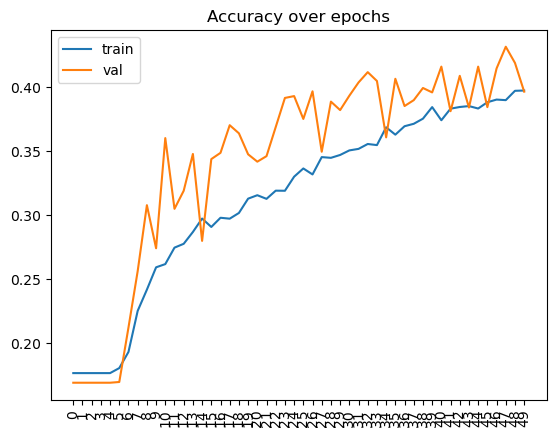

In [23]:
plt.plot(data_aug_history.history["accuracy"], label="train")
plt.plot(data_aug_history.history["val_accuracy"], label="val")
plt.xticks(np.arange(50), rotation=90)
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

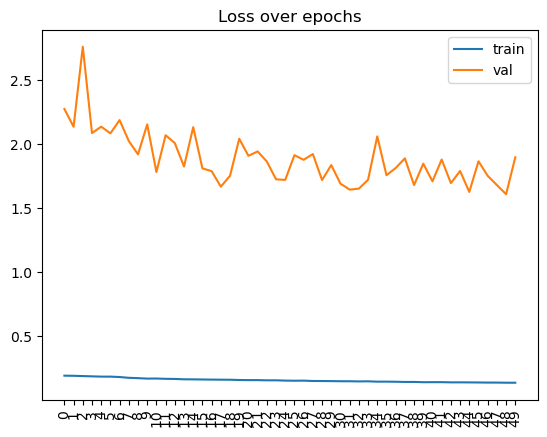

In [24]:
plt.plot(data_aug_history.history["loss"], label="train")
plt.plot(data_aug_history.history["val_loss"], label="val")
plt.xticks(np.arange(50), rotation=90)
plt.legend()
plt.title("Loss over epochs")
plt.show()

**Evaluation**

I applied 4 different types of augmentation and training set accuracy struggled to improve within the number of epochs. Both the training and validation set failed to get an accuracy of higher than 0.42.

Is there a problem with our augmentation? We are already dealing with very small images and it's possible that the augmentation is too much. Then again, the steady increase in accuracy in both sets suggests that the model is learning and perhaps more effectively.

Does the model just need more time? This is a possible conclusion since both loss and accuracy are improving.

**Next Steps**

I want to experiment with other changes and augmenting the images and training the model over more epochs takes time.

- augmentation: Before training the final model, I will try training the model with augmented images and compare but for now, to save time, I will not augment the images.
- epochs: I will limit the epochs to 30 to save time

### 3. Modifying the Learning Rate

The default learning rate is `0.001`. We can experiment to see if a slower or faster learning rate works better for this model.

In [25]:
# Do not augment the images to save time
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=False, batch_size=32)

lr_scores = {}

for lr in [0.0001,0.001,0.01,0.1]:
    print(lr)
    
    model = build_model(learning_rate=lr)

    history = model.fit(
        train_dataset,          
        epochs=30,  # Keep epochs to 30         
        validation_data=val_dataset,
        class_weight=class_weight_dict
    )
    lr_scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1681 - loss: 0.2278 - val_accuracy: 0.1694 - val_loss: 2.4225
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1805 - loss: 0.1955 - val_accuracy: 0.1694 - val_loss: 2.0378
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1786 - loss: 0.1934 - val_accuracy: 0.1694 - val_loss: 2.1634
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1623 - loss: 0.1874 - val_accuracy: 0.1694 - val_loss: 2.0788
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1717 - loss: 0.1851 - val_accuracy: 0.1694 - val_loss: 2.2850
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1932 - loss: 0.1844 - val_accuracy: 0.1714 - val_loss: 2.0715
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1772 - loss: 0.1822 - val_accuracy: 0.1719 - val_loss: 2.2665
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1743 - loss: 0.1774 - val_accu

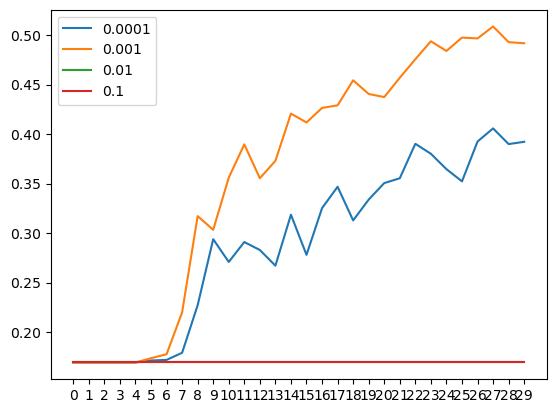

In [26]:
for lr, hist in lr_scores.items():
    plt.plot(hist["val_accuracy"], label=lr)
plt.xticks(np.arange(30))
plt.legend()
plt.show()

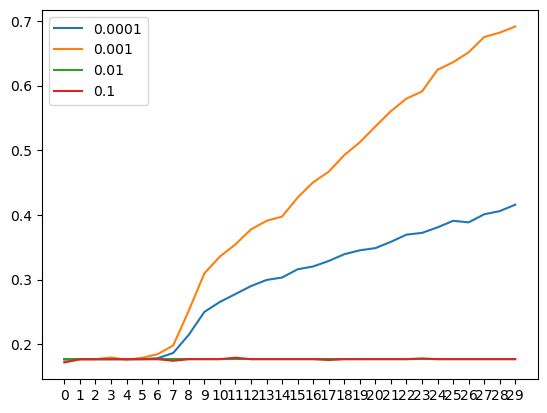

In [28]:
for lr, hist in lr_scores.items():
    plt.plot(hist["accuracy"], label=lr)
plt.xticks(np.arange(30))
plt.legend()
plt.show()

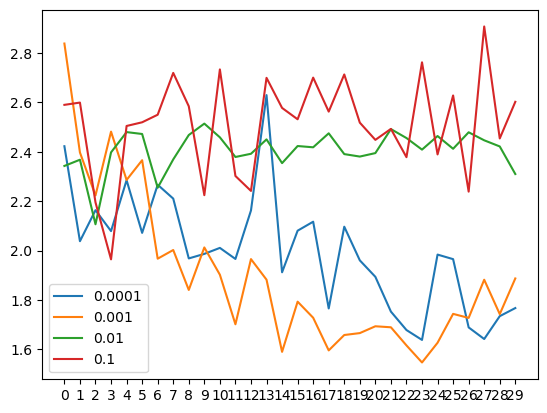

In [27]:
for lr, hist in lr_scores.items():
    plt.plot(hist["val_loss"], label=lr)
plt.xticks(np.arange(30))
plt.legend()
plt.show()

**Evaluation**

It looks like the higher learning rates (0.01 and 0.1) are too much for this dataset.

While the default `0.001` appears to perform better here I'm curious to see how the lower training rate might do if we train the model for more epochs. 

**Next steps**

We will stick with the default learning rate and see if we can make improvements in other ways.

- learning_rate = 0.001

### 4. Modifying the Dense layers

More layers means more complexity. Our base model has 2 dense layers, excluding the output layer.

If the model is underfitting, it means that it is not capturing enough patterns and so adding additional dense layers may prove helpful.

If the model is overfitting and performing too well on training data but badly on new data then removing layers can simplify the model and improve generalization.

We will try a few permutations, ranging from removing the 2 additional layers entirely to adding an extra one.

In [30]:
# We will not augment the images for just now
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=False, batch_size=32)

# Choose default learning rate from analysis above
learning_rate=0.001
dlu_scores = {}

dlu_array = [[],[32],[64,32],[128,64],[128,64,32]]

for idx, dlu in enumerate(dlu_array):
    print(dlu)
    
    model = build_model(learning_rate=learning_rate,dense_layer_units=dlu)

    history = model.fit(
        train_dataset,          
        epochs=30,           
        validation_data=val_dataset,
        class_weight=class_weight_dict
    )
    dlu_scores[idx] = history.history

    print()
    print()

[]
Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.1729 - loss: 0.2160 - val_accuracy: 0.1694 - val_loss: 2.6305
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1672 - loss: 0.1891 - val_accuracy: 0.1694 - val_loss: 3.3143
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1784 - loss: 0.1957 - val_accuracy: 0.1694 - val_loss: 2.3963
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1711 - loss: 0.1919 - val_accuracy: 0.1694 - val_loss: 2.1353
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1849 - loss: 0.1888 - val_accuracy: 0.1694 - val_loss: 2.2318
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1660 - loss: 0.1892 - val_accuracy: 0.1742 - val_loss: 2.2148
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2089 - loss: 0.1836 - val_accuracy: 0.1898 - val_loss: 2.1477
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1893 - loss: 0.1811 - val_accuracy:

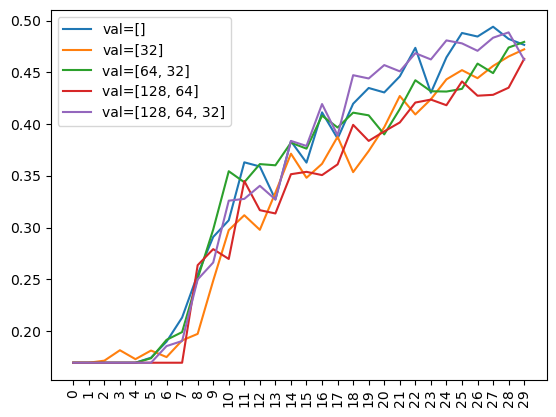

In [40]:
for idx_dlu, hist in dlu_scores.items():
    plt.plot(hist["val_accuracy"], label=(f'val={dlu_array[idx_dlu]}'))
plt.xticks(np.arange(30), rotation=90)
plt.legend()
plt.show()

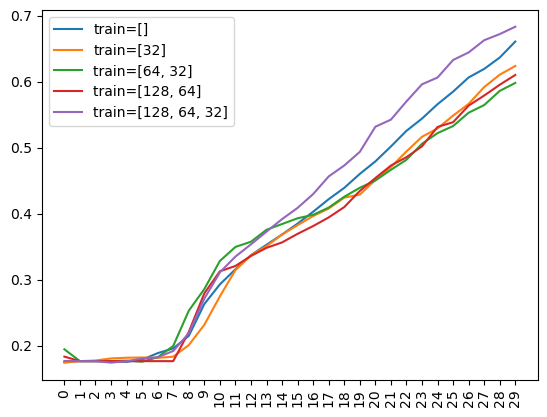

In [37]:
for idx_dlu, hist in dlu_scores.items():
    plt.plot(hist["accuracy"], label=(f'train={dlu_array[idx_dlu]}'))
plt.xticks(np.arange(30), rotation=90)
plt.legend()
plt.show()

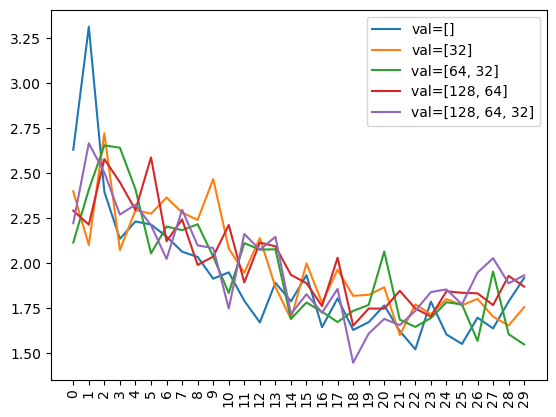

In [36]:
for idx_dlu, hist in dlu_scores.items():
    plt.plot(hist["val_loss"], label=(f'val={dlu_array[idx_dlu]}'))
plt.xticks(np.arange(30), rotation=90)
plt.legend()
plt.show()

**Evaluation**

Our original model was built with 2 additional dense layers of size 128 and 64. The results above suggest this wasn't the best choice for our problem. It looks like even excluding these dense layers would have been a good idea!

Given the upturn of loss toward the end and the training accuracy are more divergent when we don't add any dense layers in I'm not going to pick this option. The best option from the results above is an architecture with 2 additional layers with 64 and then 32 units: it has the best loss and accuracy score for the validaton set. It also looks like if we run the model for more epochs with this model configuration we will get better results.

**Next Steps**

Use an architectuer with 2 additional layers with 64 and 32 units:

- dense_layer_units = [64,32]

### 5. Regularization via Dropout

Dropout is a way of regularizing our neural net. We want to reduce the liklihood that our model will learn an irrelevant rule. Dropout forces the model to focus on the bigger picture and can prevent overfitting.

During training we randomly drop or deactive a certain percentage of neurons in a layer which temporarily makes them inactive in that training step which means their outputs don't contribute to the forward pass or the gradient updates during back propagation. When neurons are dropped randomly, the network can't rely on a given neuron, which prevents overfitting.

In [42]:
# Do not augment images in training set
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=False, batch_size=32)

learning_rate=0.001
dense_layer_units = [64,32]

dr_scores = {}

for dr in [0.0,0.2,0.5,0.8]:
    print(dr)
    
    model = build_model(learning_rate=learning_rate,dense_layer_units=dense_layer_units, drop_rate=dr)

    history = model.fit(
        train_dataset,          
        epochs=30,           
        validation_data=val_dataset,
        class_weight=class_weight_dict
    )
    dr_scores[dr] = history.history

    print()
    print()

0.0
Epoch 1/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1677 - loss: 0.2352 - val_accuracy: 0.1694 - val_loss: 2.7488
Epoch 2/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1865 - loss: 0.1957 - val_accuracy: 0.1694 - val_loss: 2.1424
Epoch 3/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1616 - loss: 0.1888 - val_accuracy: 0.1694 - val_loss: 2.4330
Epoch 4/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1670 - loss: 0.1908 - val_accuracy: 0.1694 - val_loss: 2.2947
Epoch 5/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1680 - loss: 0.1902 - val_accuracy: 0.1757 - val_loss: 2.3411
Epoch 6/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1726 - loss: 0.1809 - val_accuracy: 0.1754 - val_loss: 2.2779
Epoch 7/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1804 - loss: 0.1793 - val_accuracy: 0.1892 - val_loss: 2.5852
Epoch 8/30
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1872 - loss: 0.1822 - val_accurac

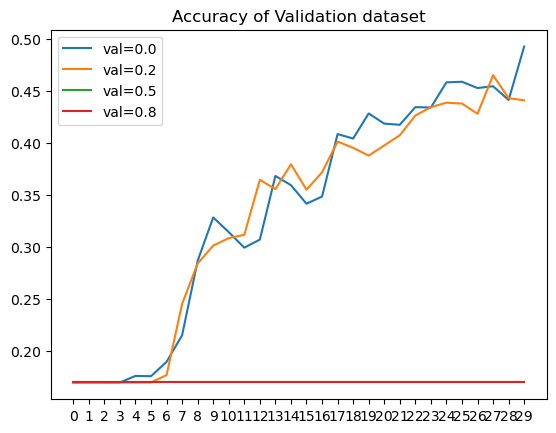

In [43]:
for dr, hist in dr_scores.items():
    #plt.plot(hist["accuracy"], label=(f'train={dr}'))
    plt.plot(hist["val_accuracy"], label=(f'val={dr}'))
plt.xticks(np.arange(30))
#plt.yticks([0.78,0.80,0.82,0.825,0.83])
plt.legend()
plt.title("Accuracy of Validation dataset")
plt.show()

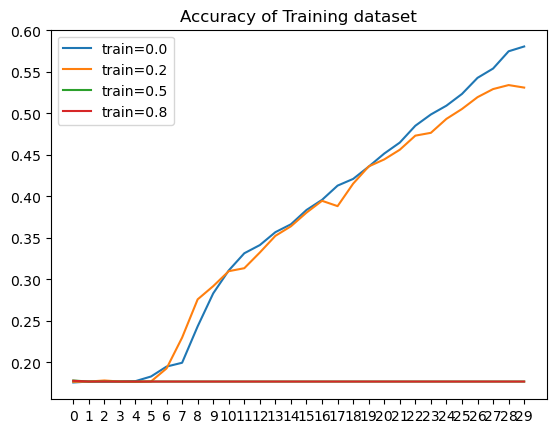

In [44]:
for dr, hist in dr_scores.items():
    plt.plot(hist["accuracy"], label=(f'train={dr}'))
plt.xticks(np.arange(30))
plt.legend()
plt.title("Accuracy of Training dataset")
plt.show()

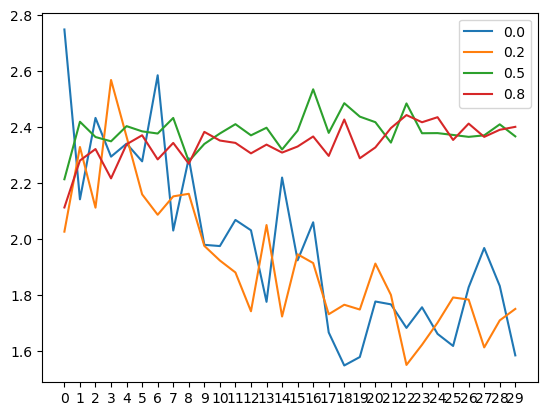

In [45]:
for dr, hist in dr_scores.items():
    plt.plot(hist["val_loss"], label=dr)
plt.xticks(np.arange(30))
plt.legend()
plt.show()

**Evaluation**

Since we added a way to combat class imbalance to our model, we have not had an overfitting issue really so it is perhaps not surprising that adding dropout doesn't improve scores. For just now, we will stick with a drop_rate of zero.

**Next steps**
Do not add regularization.

- drop_rate =0.0

## Building our Final Model

Unfortunately the model has not improved much with tweaks. Given that the training dataset accuracy and validation dataset accuracy appears to be increasing at the final epoch I have tested at (and the loss decreasing), I am hopeful that by increasing the number of epochs, allowing the model to train for longer, I will get better results.

For that reason, the final model will be trained for 100 epochs.

In [46]:
# Do not use augmentation
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=False, batch_size=32)

learning_rate=0.001
dense_layer_units = [64,32]
drop_rate = 0.0

final_model = build_model(learning_rate=learning_rate,dense_layer_units=dense_layer_units, drop_rate=drop_rate)

checkpoint = keras.callbacks.ModelCheckpoint('er_final_{epoch:02d}_{val_accuracy:.3f}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max'
                               )

final_history = final_model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[checkpoint])

Epoch 1/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.2251 - loss: 1.8655 - val_accuracy: 0.2516 - val_loss: 1.8159
Epoch 2/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2658 - loss: 1.7871 - val_accuracy: 0.2516 - val_loss: 1.8079
Epoch 3/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2736 - loss: 1.8167 - val_accuracy: 0.2550 - val_loss: 1.8028
Epoch 4/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2595 - loss: 1.8239 - val_accuracy: 0.2616 - val_loss: 1.8051
Epoch 5/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2852 - loss: 1.7856 - val_accuracy: 0.2645 - val_loss: 1.7929
Epoch 6/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2528 - loss: 1.7849 - val_accuracy: 0.2516 - val_loss: 1.7821
Epoch 7/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2694 - loss: 1.7653 - val_accuracy: 0.2542 - val_loss: 1.7310
Epoch 8/100
837/837 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2817 - loss: 1.7087 - val_acc

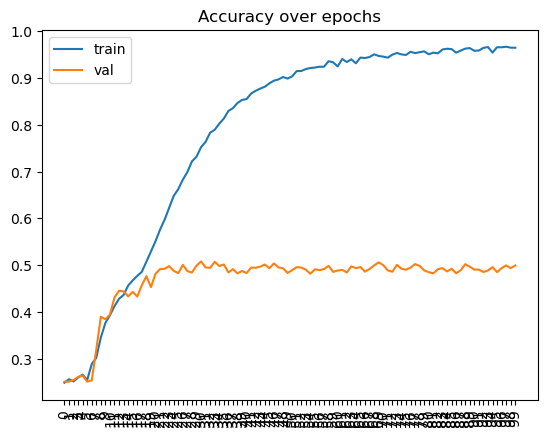

In [48]:
plt.plot(final_history.history["accuracy"], label="train")
plt.plot(final_history.history["val_accuracy"], label="val")
plt.xticks(np.arange(100), rotation=90)
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

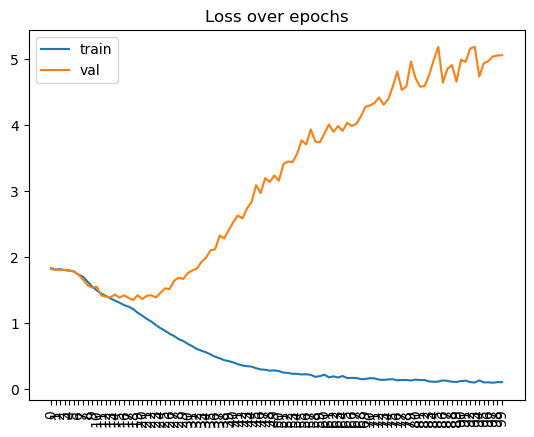

In [49]:
plt.plot(final_history.history["loss"], label="train")
plt.plot(final_history.history["val_loss"], label="val")
plt.xticks(np.arange(100), rotation=90)
plt.legend()
plt.title("Loss over epochs")
plt.show()

**Evaluate**

Unfortunately training for longer didn't improve the accuracy or the loss.

Our best model was achieved after 31 epochs and got a score on the validation set of 0.508. 

### Another model with augmentation

We saw that the training model accuracy was slow to converge with augmentation, perhaps if we train a model with augmented data for longer we will get better results.

In [50]:
# Use
train_dataset = create_dataset(train_image_paths, train_labels, label_encoder, should_augment_image=True, batch_size=32)

learning_rate=0.001
dense_layer_units = [64,32]
drop_rate = 0.0

final_with_aug_model = build_model(learning_rate=learning_rate,dense_layer_units=dense_layer_units, drop_rate=drop_rate)

checkpoint = keras.callbacks.ModelCheckpoint('er_final_with_aug_{epoch:02d}_{val_accuracy:.3f}.keras',
                                save_best_only=True,
                                monitor='val_accuracy',
                                mode='max'
                               )

final_with_aug_history = final_with_aug_model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[checkpoint])

Epoch 1/100


2025-01-25 13:29:54.688138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 401 of 1000
2025-01-25 13:30:04.691419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 809 of 1000
2025-01-25 13:30:05.354323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.2576 - loss: 1.8665 - val_accuracy: 0.1694 - val_loss: 1.8289
Epoch 2/100


2025-01-25 13:30:21.192325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 404 of 1000
2025-01-25 13:30:31.197837: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 814 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2273 - loss: 1.8569

2025-01-25 13:30:31.738140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2185 - loss: 1.8315 - val_accuracy: 0.2312 - val_loss: 1.8385
Epoch 3/100


2025-01-25 13:30:45.139370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 400 of 1000
2025-01-25 13:30:55.154346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 805 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2680 - loss: 1.8393

2025-01-25 13:30:55.956235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2372 - loss: 1.8274 - val_accuracy: 0.2516 - val_loss: 1.8082
Epoch 4/100


2025-01-25 13:31:09.371409: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 405 of 1000
2025-01-25 13:31:19.387024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 812 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1713 - loss: 1.8758

2025-01-25 13:31:19.987015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2428 - loss: 1.8148 - val_accuracy: 0.2593 - val_loss: 1.7901
Epoch 5/100


2025-01-25 13:31:33.434683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 408 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1828 - loss: 1.8960

2025-01-25 13:31:43.874759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2599 - loss: 1.7891 - val_accuracy: 0.2657 - val_loss: 1.7817
Epoch 6/100


2025-01-25 13:31:57.309200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 408 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1797 - loss: 2.0049

2025-01-25 13:32:07.624315: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2502 - loss: 1.8049 - val_accuracy: 0.2542 - val_loss: 1.7842
Epoch 7/100


2025-01-25 13:32:21.009657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 398 of 1000
2025-01-25 13:32:31.029364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 802 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4523 - loss: 1.6466

2025-01-25 13:32:31.879793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2588 - loss: 1.7704 - val_accuracy: 0.3197 - val_loss: 1.7287
Epoch 8/100


2025-01-25 13:32:45.300006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 412 of 1000
2025-01-25 13:32:55.300867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 826 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2937 - loss: 1.7094

2025-01-25 13:32:55.552455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.2878 - loss: 1.7432 - val_accuracy: 0.3266 - val_loss: 1.6899
Epoch 9/100


2025-01-25 13:33:09.014064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 410 of 1000
2025-01-25 13:33:19.019031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 824 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2559 - loss: 1.8299

2025-01-25 13:33:19.322334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3152 - loss: 1.7257 - val_accuracy: 0.3643 - val_loss: 1.6328
Epoch 10/100


2025-01-25 13:33:32.782793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 400 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3350 - loss: 1.7093

2025-01-25 13:33:43.675546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3171 - loss: 1.6896 - val_accuracy: 0.3830 - val_loss: 1.6009
Epoch 11/100


2025-01-25 13:33:57.190594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 405 of 1000
2025-01-25 13:34:07.191937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 814 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3137 - loss: 1.6628

2025-01-25 13:34:07.744928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3569 - loss: 1.6303 - val_accuracy: 0.3729 - val_loss: 1.5961
Epoch 12/100


2025-01-25 13:34:21.163513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 410 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3065 - loss: 1.7347

2025-01-25 13:34:31.484157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3618 - loss: 1.6080 - val_accuracy: 0.4132 - val_loss: 1.5012
Epoch 13/100


2025-01-25 13:34:44.912747: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 386 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4197 - loss: 1.5310

2025-01-25 13:34:56.610406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.3750 - loss: 1.5637 - val_accuracy: 0.4022 - val_loss: 1.5068
Epoch 14/100


2025-01-25 13:35:10.007200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 403 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4631 - loss: 1.4738

2025-01-25 13:35:20.752309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4074 - loss: 1.5157 - val_accuracy: 0.4313 - val_loss: 1.4561
Epoch 15/100


2025-01-25 13:35:34.194914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 401 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4205 - loss: 1.4765

2025-01-25 13:35:44.957143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4085 - loss: 1.5117 - val_accuracy: 0.4183 - val_loss: 1.4560
Epoch 16/100


2025-01-25 13:35:58.345954: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 398 of 1000
2025-01-25 13:36:08.364755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 801 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2994 - loss: 1.6092

2025-01-25 13:36:09.256975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4040 - loss: 1.4866 - val_accuracy: 0.4313 - val_loss: 1.4124
Epoch 17/100


2025-01-25 13:36:22.700921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 397 of 1000
2025-01-25 13:36:32.715256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 803 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4176 - loss: 1.4656

2025-01-25 13:36:33.536737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4146 - loss: 1.4789 - val_accuracy: 0.3827 - val_loss: 1.5014
Epoch 18/100


2025-01-25 13:36:46.908019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 408 of 1000
2025-01-25 13:36:56.910676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 819 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4320 - loss: 1.4201

2025-01-25 13:36:57.330003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4251 - loss: 1.4512 - val_accuracy: 0.4270 - val_loss: 1.4272
Epoch 19/100


2025-01-25 13:37:10.756628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 409 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3930 - loss: 1.5287

2025-01-25 13:37:21.145250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4264 - loss: 1.4529 - val_accuracy: 0.4448 - val_loss: 1.4207
Epoch 20/100


2025-01-25 13:37:34.558219: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 405 of 1000
2025-01-25 13:37:44.565367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 813 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4163 - loss: 1.4789

2025-01-25 13:37:45.132996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4512 - loss: 1.4028 - val_accuracy: 0.4577 - val_loss: 1.3933
Epoch 21/100


2025-01-25 13:37:58.567815: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 406 of 1000
2025-01-25 13:38:08.582297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 821 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4175 - loss: 1.4877

2025-01-25 13:38:08.953401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4480 - loss: 1.4174 - val_accuracy: 0.4684 - val_loss: 1.3613
Epoch 22/100


2025-01-25 13:38:22.431517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 407 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4135 - loss: 1.4369

2025-01-25 13:38:32.909708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4487 - loss: 1.4123 - val_accuracy: 0.4830 - val_loss: 1.3425
Epoch 23/100


2025-01-25 13:38:46.362085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 400 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4008 - loss: 1.5993

2025-01-25 13:38:57.193317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4377 - loss: 1.4325 - val_accuracy: 0.4934 - val_loss: 1.3190
Epoch 24/100


2025-01-25 13:39:10.663902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 407 of 1000
2025-01-25 13:39:20.676026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 818 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4819 - loss: 1.3741

2025-01-25 13:39:21.141190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4774 - loss: 1.3692 - val_accuracy: 0.4862 - val_loss: 1.3220
Epoch 25/100


2025-01-25 13:39:34.521028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 412 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4485 - loss: 1.5903

2025-01-25 13:39:44.763671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4652 - loss: 1.3963 - val_accuracy: 0.4845 - val_loss: 1.3343
Epoch 26/100


2025-01-25 13:39:58.136133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 400 of 1000
2025-01-25 13:40:08.141431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 803 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4866 - loss: 1.2839

2025-01-25 13:40:08.963414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4735 - loss: 1.3459 - val_accuracy: 0.4914 - val_loss: 1.3257
Epoch 27/100


2025-01-25 13:40:22.377677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 402 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4895 - loss: 1.4036

2025-01-25 13:40:33.084670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4646 - loss: 1.3900 - val_accuracy: 0.5000 - val_loss: 1.3078
Epoch 28/100


2025-01-25 13:40:46.518303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 407 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4096 - loss: 1.5512

2025-01-25 13:40:57.001439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4734 - loss: 1.3753 - val_accuracy: 0.5009 - val_loss: 1.3075
Epoch 29/100


2025-01-25 13:41:10.462419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 389 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5674 - loss: 1.1992

2025-01-25 13:41:21.893702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.4901 - loss: 1.3280 - val_accuracy: 0.4908 - val_loss: 1.3176
Epoch 30/100


2025-01-25 13:41:35.273580: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 399 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5201 - loss: 1.2700

2025-01-25 13:41:46.192873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4831 - loss: 1.3420 - val_accuracy: 0.4963 - val_loss: 1.3235
Epoch 31/100


2025-01-25 13:41:59.605419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 402 of 1000
2025-01-25 13:42:09.608944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 806 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4222 - loss: 1.4390

2025-01-25 13:42:10.360216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4842 - loss: 1.3373 - val_accuracy: 0.4963 - val_loss: 1.3020
Epoch 32/100


2025-01-25 13:42:23.773407: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 399 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4917 - loss: 1.3434

2025-01-25 13:42:34.686201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4970 - loss: 1.3146 - val_accuracy: 0.5043 - val_loss: 1.2945
Epoch 33/100


2025-01-25 13:42:48.124991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 403 of 1000
2025-01-25 13:42:58.129529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 811 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6473 - loss: 1.0510

2025-01-25 13:42:58.748151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5141 - loss: 1.2754 - val_accuracy: 0.4741 - val_loss: 1.3337
Epoch 34/100


2025-01-25 13:43:12.144880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 406 of 1000
2025-01-25 13:43:22.146592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 815 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5512 - loss: 1.2033

2025-01-25 13:43:22.667692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5048 - loss: 1.2926 - val_accuracy: 0.4934 - val_loss: 1.3293
Epoch 35/100


2025-01-25 13:43:36.066095: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 412 of 1000
2025-01-25 13:43:46.080373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 826 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5616 - loss: 1.1793

2025-01-25 13:43:46.328542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5100 - loss: 1.2887 - val_accuracy: 0.4505 - val_loss: 1.4394
Epoch 36/100


2025-01-25 13:43:59.726456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 401 of 1000
2025-01-25 13:44:09.731193: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 804 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4463 - loss: 1.4152

2025-01-25 13:44:10.569858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4923 - loss: 1.3265 - val_accuracy: 0.4600 - val_loss: 1.4388
Epoch 37/100


2025-01-25 13:44:23.962014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 410 of 1000
2025-01-25 13:44:33.962584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 825 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4838 - loss: 1.3506

2025-01-25 13:44:34.236688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5071 - loss: 1.2934 - val_accuracy: 0.4994 - val_loss: 1.3059
Epoch 38/100


2025-01-25 13:44:47.663754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 411 of 1000
2025-01-25 13:44:57.673531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 825 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5450 - loss: 1.2376

2025-01-25 13:44:57.946308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.4997 - loss: 1.3073 - val_accuracy: 0.5098 - val_loss: 1.2790
Epoch 39/100


2025-01-25 13:45:11.391556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 404 of 1000
2025-01-25 13:45:21.398139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 813 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5254 - loss: 1.2674

2025-01-25 13:45:21.976026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5218 - loss: 1.2540 - val_accuracy: 0.5020 - val_loss: 1.3216
Epoch 40/100


2025-01-25 13:45:35.345605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 404 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4662 - loss: 1.3649

2025-01-25 13:45:46.023587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5061 - loss: 1.2969 - val_accuracy: 0.5078 - val_loss: 1.2953
Epoch 41/100


2025-01-25 13:45:59.437146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 410 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4918 - loss: 1.2749

2025-01-25 13:46:09.866828: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5267 - loss: 1.2421 - val_accuracy: 0.5060 - val_loss: 1.2996
Epoch 42/100


2025-01-25 13:46:23.297604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 396 of 1000
2025-01-25 13:46:33.308223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 795 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4993 - loss: 1.2559

2025-01-25 13:46:34.341803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5237 - loss: 1.2520 - val_accuracy: 0.4810 - val_loss: 1.3261
Epoch 43/100


2025-01-25 13:46:47.747890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 406 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5685 - loss: 1.1814

2025-01-25 13:46:58.332380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5128 - loss: 1.2651 - val_accuracy: 0.5066 - val_loss: 1.2758
Epoch 44/100


2025-01-25 13:47:11.730007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 409 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5352 - loss: 1.2133

2025-01-25 13:47:22.111163: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5152 - loss: 1.2671 - val_accuracy: 0.5109 - val_loss: 1.2856
Epoch 45/100


2025-01-25 13:47:35.531191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 396 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5415 - loss: 1.2241

2025-01-25 13:47:46.673699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5196 - loss: 1.2576 - val_accuracy: 0.5193 - val_loss: 1.2605
Epoch 46/100


2025-01-25 13:48:00.131606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 404 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5802 - loss: 1.1486

2025-01-25 13:48:10.865279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5125 - loss: 1.2568 - val_accuracy: 0.5296 - val_loss: 1.2353
Epoch 47/100


2025-01-25 13:48:24.286683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 398 of 1000
2025-01-25 13:48:34.293033: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 804 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6147 - loss: 1.0478

2025-01-25 13:48:35.085959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5209 - loss: 1.2419 - val_accuracy: 0.5242 - val_loss: 1.2392
Epoch 48/100


2025-01-25 13:48:48.493403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 399 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5438 - loss: 1.1926

2025-01-25 13:48:59.448853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5258 - loss: 1.2371 - val_accuracy: 0.5265 - val_loss: 1.2345
Epoch 49/100


2025-01-25 13:49:12.871661: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 408 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5761 - loss: 1.1480

2025-01-25 13:49:23.269558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5293 - loss: 1.2403 - val_accuracy: 0.5060 - val_loss: 1.2969
Epoch 50/100


2025-01-25 13:49:36.672927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 411 of 1000
2025-01-25 13:49:46.679104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 825 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5208 - loss: 1.3220

2025-01-25 13:49:46.953784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5167 - loss: 1.2685 - val_accuracy: 0.5250 - val_loss: 1.2494
Epoch 51/100


2025-01-25 13:50:00.368667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 408 of 1000
2025-01-25 13:50:10.370743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 821 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4753 - loss: 1.3606

2025-01-25 13:50:10.782065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5240 - loss: 1.2498 - val_accuracy: 0.5299 - val_loss: 1.2367
Epoch 52/100


2025-01-25 13:50:24.205408: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 399 of 1000
2025-01-25 13:50:34.208915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 804 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5237 - loss: 1.2464

2025-01-25 13:50:34.999313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5265 - loss: 1.2404 - val_accuracy: 0.5382 - val_loss: 1.2242
Epoch 53/100


2025-01-25 13:50:48.436434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 410 of 1000
2025-01-25 13:50:58.446185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 825 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5733 - loss: 1.0834

2025-01-25 13:50:58.724250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5392 - loss: 1.2073 - val_accuracy: 0.5086 - val_loss: 1.2781
Epoch 54/100


2025-01-25 13:51:12.145395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 409 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5523 - loss: 1.2063

2025-01-25 13:51:22.447497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5360 - loss: 1.2162 - val_accuracy: 0.5411 - val_loss: 1.2071
Epoch 55/100


2025-01-25 13:51:35.940342: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 406 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6161 - loss: 1.0556

2025-01-25 13:51:46.487613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5399 - loss: 1.2178 - val_accuracy: 0.5411 - val_loss: 1.2218
Epoch 56/100


2025-01-25 13:51:59.893916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 409 of 1000
2025-01-25 13:52:09.905512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 822 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5330 - loss: 1.2316

2025-01-25 13:52:10.259038: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5364 - loss: 1.2220 - val_accuracy: 0.5259 - val_loss: 1.2458
Epoch 57/100


2025-01-25 13:52:23.674290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 404 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5473 - loss: 1.1901

2025-01-25 13:52:34.252368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5345 - loss: 1.2166 - val_accuracy: 0.5342 - val_loss: 1.2208
Epoch 58/100


2025-01-25 13:52:47.646653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 402 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5242 - loss: 1.2306

2025-01-25 13:52:58.412988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5408 - loss: 1.2054 - val_accuracy: 0.5426 - val_loss: 1.2143
Epoch 59/100


2025-01-25 13:53:11.844361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 408 of 1000
2025-01-25 13:53:21.849204: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 817 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5069 - loss: 1.2097

2025-01-25 13:53:22.315012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5387 - loss: 1.2022 - val_accuracy: 0.5371 - val_loss: 1.2099
Epoch 60/100


2025-01-25 13:53:35.697089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 402 of 1000
2025-01-25 13:53:45.707364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 803 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4505 - loss: 1.3364

2025-01-25 13:53:46.558745: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5247 - loss: 1.2301 - val_accuracy: 0.5420 - val_loss: 1.2245
Epoch 61/100


2025-01-25 13:53:59.938081: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 388 of 1000
2025-01-25 13:54:09.946227: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 779 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5304 - loss: 1.1712

2025-01-25 13:54:11.434308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5512 - loss: 1.1774 - val_accuracy: 0.5313 - val_loss: 1.2335
Epoch 62/100


2025-01-25 13:54:24.829302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 397 of 1000
2025-01-25 13:54:34.831303: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 800 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5649 - loss: 1.1246

2025-01-25 13:54:35.776203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5583 - loss: 1.1743 - val_accuracy: 0.5403 - val_loss: 1.2296
Epoch 63/100


2025-01-25 13:54:49.201291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 413 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5498 - loss: 1.1814

2025-01-25 13:54:59.428842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5362 - loss: 1.2046 - val_accuracy: 0.5391 - val_loss: 1.2260
Epoch 64/100


2025-01-25 13:55:12.804824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 396 of 1000
2025-01-25 13:55:22.822353: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 795 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5018 - loss: 1.2600

2025-01-25 13:55:23.866237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5363 - loss: 1.2120 - val_accuracy: 0.5472 - val_loss: 1.2083
Epoch 65/100


2025-01-25 13:55:37.327397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 407 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5797 - loss: 1.1433

2025-01-25 13:55:47.815681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5431 - loss: 1.1898 - val_accuracy: 0.5382 - val_loss: 1.2308
Epoch 66/100


2025-01-25 13:56:01.222656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 410 of 1000
2025-01-25 13:56:11.231108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 822 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4466 - loss: 1.4207

2025-01-25 13:56:11.577510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5426 - loss: 1.2062 - val_accuracy: 0.5336 - val_loss: 1.2403
Epoch 67/100


2025-01-25 13:56:24.987603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 403 of 1000
2025-01-25 13:56:34.992732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 814 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5489 - loss: 1.1046

2025-01-25 13:56:35.528854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5455 - loss: 1.1830 - val_accuracy: 0.5466 - val_loss: 1.2253
Epoch 68/100


2025-01-25 13:56:48.941630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 398 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5869 - loss: 1.1348

2025-01-25 13:56:59.885549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5622 - loss: 1.1698 - val_accuracy: 0.5472 - val_loss: 1.2018
Epoch 69/100


2025-01-25 13:57:13.268047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 405 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5998 - loss: 1.0764

2025-01-25 13:57:23.872853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5512 - loss: 1.1806 - val_accuracy: 0.5472 - val_loss: 1.2152
Epoch 70/100


2025-01-25 13:57:37.254272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 412 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5917 - loss: 1.0902

2025-01-25 13:57:47.525557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5440 - loss: 1.1997 - val_accuracy: 0.5293 - val_loss: 1.2859
Epoch 71/100


2025-01-25 13:58:00.957574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 402 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4454 - loss: 1.5961

2025-01-25 13:58:11.645181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5302 - loss: 1.2385 - val_accuracy: 0.5564 - val_loss: 1.1947
Epoch 72/100


2025-01-25 13:58:25.068317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 412 of 1000


  1/837 ━━━━━━━━━━━━━━━━━━━━ 4:41:08 20s/step - accuracy: 0.5000 - loss: 1.6124

2025-01-25 13:58:35.077331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 830 of 1000
2025-01-25 13:58:35.231035: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5488 - loss: 1.1770 - val_accuracy: 0.5405 - val_loss: 1.2278
Epoch 73/100


2025-01-25 13:58:48.639652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 403 of 1000
2025-01-25 13:58:58.643313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 811 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5943 - loss: 1.0460

2025-01-25 13:58:59.263243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5549 - loss: 1.1742 - val_accuracy: 0.5543 - val_loss: 1.1930
Epoch 74/100


2025-01-25 13:59:12.657711: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 392 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5628 - loss: 1.1152

2025-01-25 13:59:23.943426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5576 - loss: 1.1678 - val_accuracy: 0.5262 - val_loss: 1.2621
Epoch 75/100


2025-01-25 13:59:37.333078: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 407 of 1000
2025-01-25 13:59:47.334803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 815 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5322 - loss: 1.2366

2025-01-25 13:59:47.854218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5493 - loss: 1.1797 - val_accuracy: 0.5454 - val_loss: 1.2245
Epoch 76/100


2025-01-25 14:00:01.304757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 406 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5382 - loss: 1.2188

2025-01-25 14:00:11.930243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5547 - loss: 1.1665 - val_accuracy: 0.5394 - val_loss: 1.2088
Epoch 77/100


2025-01-25 14:00:25.303031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 393 of 1000
2025-01-25 14:00:35.304527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 792 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5120 - loss: 1.2305

2025-01-25 14:00:36.458509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5559 - loss: 1.1667 - val_accuracy: 0.5480 - val_loss: 1.2043
Epoch 78/100


2025-01-25 14:00:49.854950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 403 of 1000
2025-01-25 14:00:59.871720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 811 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4758 - loss: 1.3706

2025-01-25 14:01:00.532925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5566 - loss: 1.1703 - val_accuracy: 0.5147 - val_loss: 1.2975
Epoch 79/100


2025-01-25 14:01:13.936927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 405 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5027 - loss: 1.2156

2025-01-25 14:01:24.525781: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5524 - loss: 1.1641 - val_accuracy: 0.5489 - val_loss: 1.2006
Epoch 80/100


2025-01-25 14:01:37.912237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 398 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4876 - loss: 1.2121

2025-01-25 14:01:48.922072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5457 - loss: 1.1768 - val_accuracy: 0.5463 - val_loss: 1.2201
Epoch 81/100


2025-01-25 14:02:02.366766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 408 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6107 - loss: 1.0591

2025-01-25 14:02:12.814825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5679 - loss: 1.1385 - val_accuracy: 0.5633 - val_loss: 1.1692
Epoch 82/100


2025-01-25 14:02:26.305088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 403 of 1000
2025-01-25 14:02:36.305791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 811 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5748 - loss: 1.1278

2025-01-25 14:02:36.920112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5538 - loss: 1.1657 - val_accuracy: 0.5495 - val_loss: 1.2009
Epoch 83/100


2025-01-25 14:02:50.351036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 403 of 1000


 48/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6312 - loss: 0.9897

2025-01-25 14:03:01.044212: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5745 - loss: 1.1186 - val_accuracy: 0.4865 - val_loss: 1.3666
Epoch 84/100


2025-01-25 14:03:14.426188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 396 of 1000
2025-01-25 14:03:24.436155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 799 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5413 - loss: 1.1719

2025-01-25 14:03:25.365672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5518 - loss: 1.1626 - val_accuracy: 0.5437 - val_loss: 1.2314
Epoch 85/100


2025-01-25 14:03:38.783401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 406 of 1000


 45/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5584 - loss: 1.1555

2025-01-25 14:03:49.351133: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5581 - loss: 1.1539 - val_accuracy: 0.5380 - val_loss: 1.2729
Epoch 86/100


2025-01-25 14:04:02.799746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 403 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5782 - loss: 1.1337

2025-01-25 14:04:13.566276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5735 - loss: 1.1349 - val_accuracy: 0.5443 - val_loss: 1.2426
Epoch 87/100


2025-01-25 14:04:27.001510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 397 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5721 - loss: 1.1590

2025-01-25 14:04:37.889669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5617 - loss: 1.1622 - val_accuracy: 0.5311 - val_loss: 1.2681
Epoch 88/100


2025-01-25 14:04:51.321638: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 407 of 1000
2025-01-25 14:05:01.330178: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 817 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5660 - loss: 1.0936

2025-01-25 14:05:01.804069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5673 - loss: 1.1315 - val_accuracy: 0.5520 - val_loss: 1.2194
Epoch 89/100


2025-01-25 14:05:15.208994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 399 of 1000
2025-01-25 14:05:25.217980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 801 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5367 - loss: 1.1792

2025-01-25 14:05:26.178517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5663 - loss: 1.1362 - val_accuracy: 0.5497 - val_loss: 1.2033
Epoch 90/100


2025-01-25 14:05:39.609772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 392 of 1000
2025-01-25 14:05:49.611175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 788 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6328 - loss: 0.9968

2025-01-25 14:05:50.861746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5829 - loss: 1.1101 - val_accuracy: 0.5408 - val_loss: 1.2420
Epoch 91/100


2025-01-25 14:06:04.270083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 403 of 1000
2025-01-25 14:06:14.280458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 806 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5751 - loss: 1.1253

2025-01-25 14:06:15.040885: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5673 - loss: 1.1413 - val_accuracy: 0.5618 - val_loss: 1.1954
Epoch 92/100


2025-01-25 14:06:28.498928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 402 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5293 - loss: 1.2420

2025-01-25 14:06:39.209050: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5594 - loss: 1.1542 - val_accuracy: 0.5546 - val_loss: 1.1746
Epoch 93/100


2025-01-25 14:06:52.649173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 387 of 1000
2025-01-25 14:07:02.662874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 778 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6026 - loss: 1.0532

2025-01-25 14:07:04.130346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5837 - loss: 1.0948 - val_accuracy: 0.5469 - val_loss: 1.2090
Epoch 94/100


2025-01-25 14:07:17.590662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 401 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6206 - loss: 1.0568

2025-01-25 14:07:28.384311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5671 - loss: 1.1429 - val_accuracy: 0.5664 - val_loss: 1.1766
Epoch 95/100


2025-01-25 14:07:41.882280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 408 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5797 - loss: 1.0794

2025-01-25 14:07:52.284458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5715 - loss: 1.1307 - val_accuracy: 0.5543 - val_loss: 1.1806
Epoch 96/100


2025-01-25 14:08:05.738732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 391 of 1000
2025-01-25 14:08:15.754125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 786 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5538 - loss: 1.1352

2025-01-25 14:08:17.064085: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5705 - loss: 1.1278 - val_accuracy: 0.5368 - val_loss: 1.2420
Epoch 97/100


2025-01-25 14:08:46.688622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 405 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5660 - loss: 1.1659

2025-01-25 14:08:57.287060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.5602 - loss: 1.1544 - val_accuracy: 0.5561 - val_loss: 1.1788
Epoch 98/100


2025-01-25 14:09:10.734509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 408 of 1000
2025-01-25 14:09:20.736819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 817 of 1000


 47/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5990 - loss: 1.0515

2025-01-25 14:09:21.210994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5519 - loss: 1.1645 - val_accuracy: 0.5512 - val_loss: 1.1925
Epoch 99/100


2025-01-25 14:09:34.634139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 408 of 1000


 46/837 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5880 - loss: 1.1008

2025-01-25 14:09:45.104470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5816 - loss: 1.1018 - val_accuracy: 0.5541 - val_loss: 1.1940
Epoch 100/100


2025-01-25 14:09:58.532920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 401 of 1000
2025-01-25 14:10:08.545538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:105: Filling up shuffle buffer (this may take a while): 806 of 1000


 44/837 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5914 - loss: 1.0661

2025-01-25 14:10:09.298158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


837/837 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5709 - loss: 1.1198 - val_accuracy: 0.5426 - val_loss: 1.2423


**Evaluate**

The model trained on augmented data appears to keep getting better and better. It doesn't overfit on the dataset then again, should it be a concern that the accuracy of the training set never gets better than around 0.59?

The best model was achieved after 94 epochs and got a score on the validation set of 0.566, which is better than the accuracy for our other final model. 

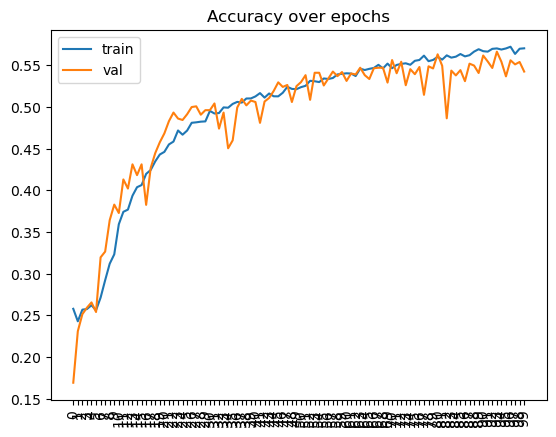

In [51]:
plt.plot(final_with_aug_history.history["accuracy"], label="train")
plt.plot(final_with_aug_history.history["val_accuracy"], label="val")
plt.xticks(np.arange(100), rotation=90)
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

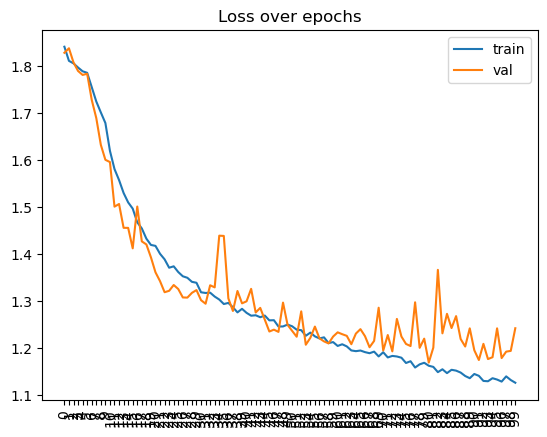

In [52]:
plt.plot(final_with_aug_history.history["loss"], label="train")
plt.plot(final_with_aug_history.history["val_loss"], label="val")
plt.xticks(np.arange(100), rotation=90)
plt.legend()
plt.title("Loss over epochs")
plt.show()

### Evaluate final models with test dataset

I have built a couple of final models: one without augmenting the training set and one with data augmentation. The validation dataset seems to perform better on the model with data augmentation but is this true of the test dataset?

In [56]:
test_data_folder = data_file_path + "test/"

meta_test = get_image_meta(test_data_folder)

df_meta_test = pd.DataFrame(meta_test)

test_labels = df_meta_test["category"].values
test_image_paths = df_meta_test["file_path"].values

test_dataset = create_dataset(test_image_paths, test_labels, label_encoder, should_augment_image=False, batch_size=32)

len(test_dataset) * 32 # should be roughly the size of the test data

3488

In [59]:
final_model_no_aug_filepath = "./er_final_31_0.508.keras"
final_model_no_aug = keras.models.load_model(final_model_no_aug_filepath)

loss, accuracy = final_model_no_aug.evaluate(test_dataset)
loss, accuracy

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5320 - loss: 1.5877


(1.6584298610687256, 0.5208632946014404)

In [58]:
final_model_with_aug_filepath = "./er_final_with_aug_94_0.566.keras"
final_model_with_aug = keras.models.load_model(final_model_with_aug_filepath)

loss, accuracy = final_model_with_aug.evaluate(test_dataset)
loss, accuracy

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5341 - loss: 1.1992


(1.1689623594284058, 0.5559712052345276)

**Conclusions**

The Evaluation seems to confirm the results of our validation dataset: our final model trained with data augmentation has the best results. It has both a higher accuracy score and a lower loss.

Although `0.556` isn't a great accuracy score - our model is only slightly better than flipping a coin! It is better than our initial model. Furthermore, given that the model trained with data augmentation appeared to be still improving, it's possible that if we trained it for longer we would get even better results. Unfortunately I don't have time to do this at the moment.

### Use the model

Below we use the model to predict one of our test images. The model successfully predicts that the image shows a person who looks angry.

In [83]:
path = data_file_path + "test/angry/PrivateTest_7833671.jpg"
img = preprocess_input(path, should_augment_image=False)
img = tf.expand_dims(
    img, axis=0
)
img.shape

TensorShape([1, 48, 48, 1])

In [84]:
pred = final_model_with_aug.predict(img)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([[0.21942854, 0.09752315, 0.2080402 , 0.02156431, 0.00439539,
        0.44714722, 0.00190112]], dtype=float32)

In [85]:
predicted_class_index = np.argmax(pred)
predicted_class_index

np.int64(5)

In [86]:
categories = list(df_meta_train["category"].unique())
categories

['sad', 'neutral', 'fear', 'surprise', 'disgust', 'angry', 'happy']

In [87]:
dict(zip(categories,pred.tolist()[0]))

{'sad': 0.21942853927612305,
 'neutral': 0.09752315282821655,
 'fear': 0.20804019272327423,
 'surprise': 0.021564306691288948,
 'disgust': 0.004395392257720232,
 'angry': 0.4471472203731537,
 'happy': 0.0019011222757399082}

In [88]:
inverse_lookup = tf.keras.layers.StringLookup(vocabulary=categories, output_mode='int', num_oov_indices=0, mask_token=None, invert=True)

predicted_label= inverse_lookup(predicted_class_index)
predicted_label.numpy()

b'angry'

In [89]:
categories[predicted_class_index]

'angry'